#### Imports

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

#### Read in Data

In [51]:
df = pd.read_csv('../data/clean_data/users-clean-data.csv')

#### Inspect 

In [52]:
df.head()

,Customer ID,Age,Gender,City,Account Type,Account Balance,Account Balance After Transaction,Credit Limit,Credit Card Balance
0,1,45,Male,Fort Worth,Current,1313.38,2770.99,1737.88,4524.32
1,2,47,Female,Louisville,Current,5988.46,7649.45,1799.36,856.70
2,3,25,Female,Philadelphia,Current,8277.88,7437.97,6112.96,3242.36
3,4,52,Other,Oklahoma City,Savings,7487.21,12396.10,2069.41,4329.17
4,5,68,Other,Phoenix,Savings,6993.55,6404.48,2765.30,25.72


In [53]:
df.shape

(5000, 9)

In [54]:
# make cols names snake_case
df.rename(columns = {
    'Customer ID': 'customer_id',
    'Age': 'age',
    'Gender': 'gender',
    'City': 'city',
    'Account Type': 'acc_type',
    'Account Balance': 'acc_bal',
    'Account Balance After Transaction': 'acc_bal_aft',
    'Credit Limit': 'credit_limit',
    'Credit Card Balance': 'credit_bal'
}, inplace = True)

# confirm
df.columns

Index(['customer_id', 'age', 'gender', 'city', 'acc_type', 'acc_bal',
       'acc_bal_aft', 'credit_limit', 'credit_bal'],
      dtype='object')

#### Set index to Customer Id

In [55]:
df.set_index('customer_id', inplace = True)

#### Drop irrelevant columns for Clustering

In [56]:
df_cluster = df.drop(columns = ['city', 'acc_type'])

#### One hot Encode for relevant columns

In [57]:
column_transformer = make_column_transformer(
    (OneHotEncoder(drop='first'), ['gender']),  
    remainder='passthrough'  
)

In [58]:
df_encoded = column_transformer.fit_transform(df_cluster)

In [59]:
df_encoded = pd.DataFrame(df_encoded, columns=column_transformer.get_feature_names_out())

#### Scaling features

In [60]:
ss = StandardScaler()
df_scaled = ss.fit_transform(df_encoded)

In [61]:
df_scaled = pd.DataFrame(df_scaled, columns=df_encoded.columns)

#### Cluster with KMeans

In [62]:
# Using default k
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(df_scaled)

C:\Users\navin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(random_state=42)

In [63]:
cluster_labels = kmeans.labels_
df['cluster'] = cluster_labels

In [64]:
# Check to see how many clusters
len(df['cluster'].unique())

8

In [65]:
df[['cluster']]

,cluster
customer_id,
1,7
2,4
3,4
4,2
5,2
...,...
4996,2
4997,0
4998,0


#### Visualize the Clusters

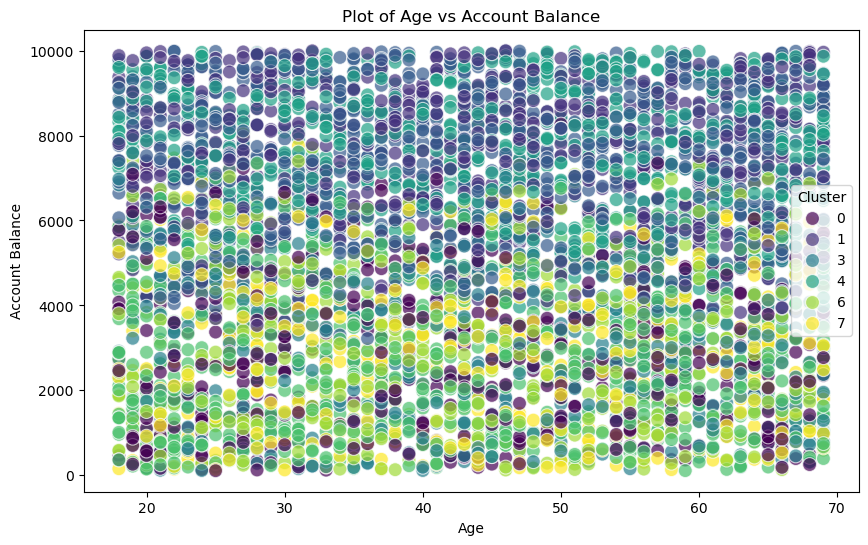

In [66]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='age', y='acc_bal', hue='cluster', palette='viridis', s=100, alpha=0.7)
plt.title( 'Plot of Age vs Account Balance')
plt.xlabel('Age')
plt.ylabel('Account Balance')
plt.legend(title='Cluster')
plt.savefig('../images/users_age_vs_acc_bal_cluster.png');

This plot is meant to the different clusters and ideally different groups of users based on factors like age and account balance. However, our data is so spread out that we are unable to see any relevant clusters. The model is unable to show us how our users are distributed. 

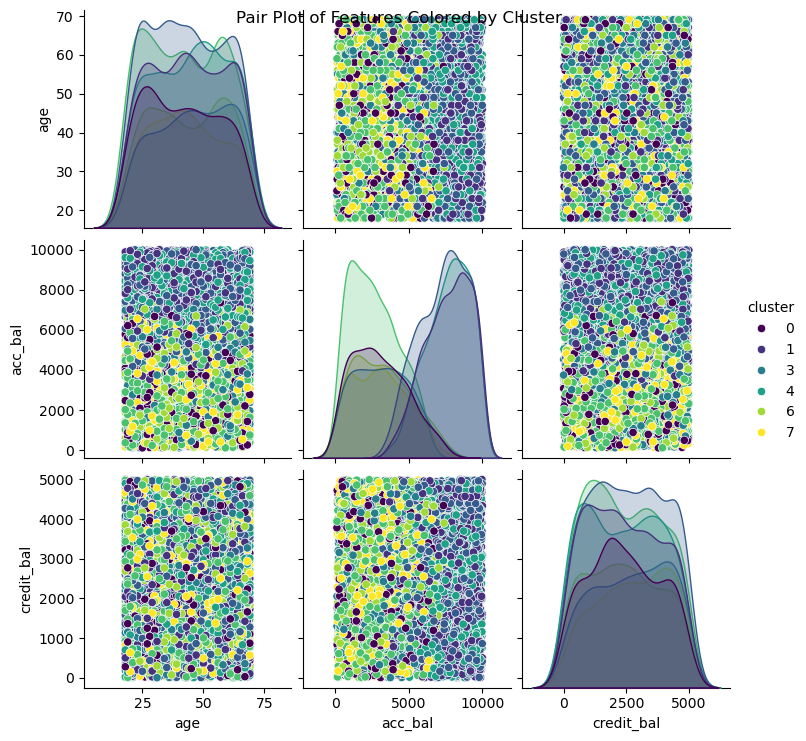

In [67]:
sns.pairplot(df, hue='cluster', vars=['age', 'acc_bal', 'credit_bal'], palette='viridis')
plt.suptitle('Pair Plot of Features Colored by Cluster')  
plt.savefig('../images/users_pairplot_cluster.png');

This is further proved by our pairplot. Here we can see that there are very little trends or patterns we can analyze using this paritcular dataset. 

#### Evaluate 

In [68]:
silhouette_score(df_scaled, cluster_labels)

0.16839026750434777

#### Try different K values

In [69]:
k_values = range(2, 11)  
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state= 42, n_init='auto')
    kmeans.fit(df_scaled)  
    cluster_labels = kmeans.labels_

    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f'Silhouette Score for K={k}: {silhouette_avg:.3f}')

Silhouette Score for K=2: 0.161
Silhouette Score for K=3: 0.178
Silhouette Score for K=4: 0.148
Silhouette Score for K=5: 0.155
Silhouette Score for K=6: 0.184
Silhouette Score for K=7: 0.170
Silhouette Score for K=8: 0.166
Silhouette Score for K=9: 0.160
Silhouette Score for K=10: 0.163


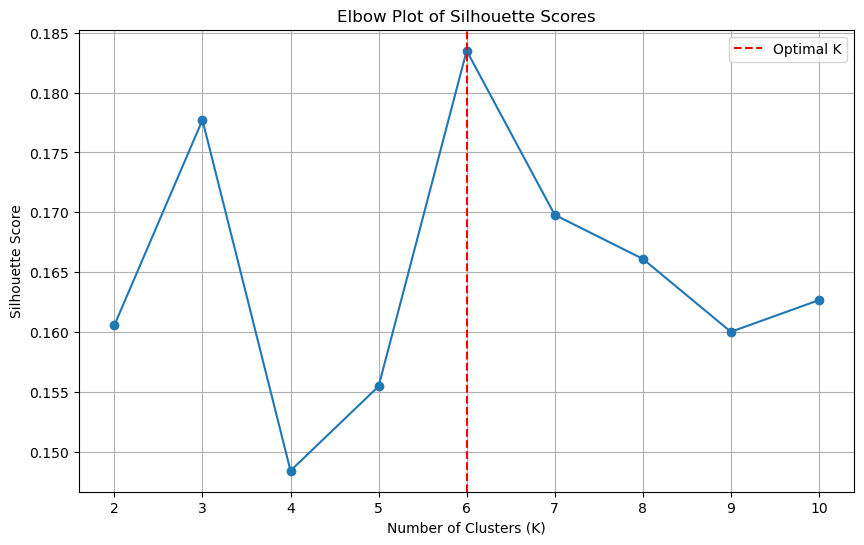

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Elbow Plot of Silhouette Scores')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid()
plt.axvline(x=k_values[silhouette_scores.index(max(silhouette_scores))], color='red', linestyle='--', label='Optimal K')
plt.legend()
plt.savefig('../images/users_elbowplot.png');

The elbow plot shows that our "ideal" number of clusters is 6. 

#### DBSCAN 

In [71]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(df_scaled)

In [72]:
df['dbscan_cluster'] = dbscan_labels

In [73]:
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0) 
n_noise = list(dbscan_labels).count(-1)

In [74]:
print(f'Number of clusters found: {n_clusters}')
print(f'Number of noise points: {n_noise}')

Number of clusters found: 23
Number of noise points: 4860


In [75]:
silhouette_score(df_scaled, dbscan.labels_)

-0.47370770211318325

In [76]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='age', y='acc_bal', hue='dbscan_cluster', palette='viridis', s=100, alpha=0.7)
plt.title('DBSCAN Clustering')
plt.xlabel('Age')
plt.ylabel('Account Balance')
plt.legend(title='Cluster')
plt.savefig('../images/users_dscan_clustering.png', bbox_inches="tight");
plt.close()

Once again, the trend continues, and it is obvious that the model is unable to cluster based on patterns in the data. This could be due to the nature of the dataset and how there is very little trends or correlations between the features as we saw in the EDA. 

In [77]:
cluster_summary = df.groupby('dbscan_cluster').agg({
    'age': ['mean', 'median'],
    'acc_bal': ['mean', 'median'],
    'credit_bal': ['mean', 'median']
}).round(2)

print("Cluster Summary Statistics:")
print(cluster_summary)

Cluster Summary Statistics:
                  age         acc_bal          credit_bal         
                 mean median     mean   median       mean   median
dbscan_cluster                                                    
-1              43.55   43.0  5084.77  5132.69    2484.64  2456.94
 0              23.83   23.5  7913.76  7674.02    2532.60  2526.30
 1              39.00   39.0  1762.96  2019.34    1145.02  1140.03
 2              46.33   46.0  5116.11  5183.08    2142.60  2174.41
 3              29.60   31.0   480.06   317.44    3497.71  3442.54
 4              61.60   62.0  6966.45  6965.40    3960.96  3956.88
 5              20.18   20.0  1492.98  1551.77    3575.77  3631.24
 6              59.29   60.0  7931.62  7879.20    1683.32  1715.46
 7              55.00   55.5  1899.36  1862.43    2580.43  2561.54
 8              24.60   24.0  5731.31  5659.11    1944.80  2064.34
 9              36.00   36.0  2781.27  2533.77    3805.93  3907.78
 10             25.50   25.5  5029

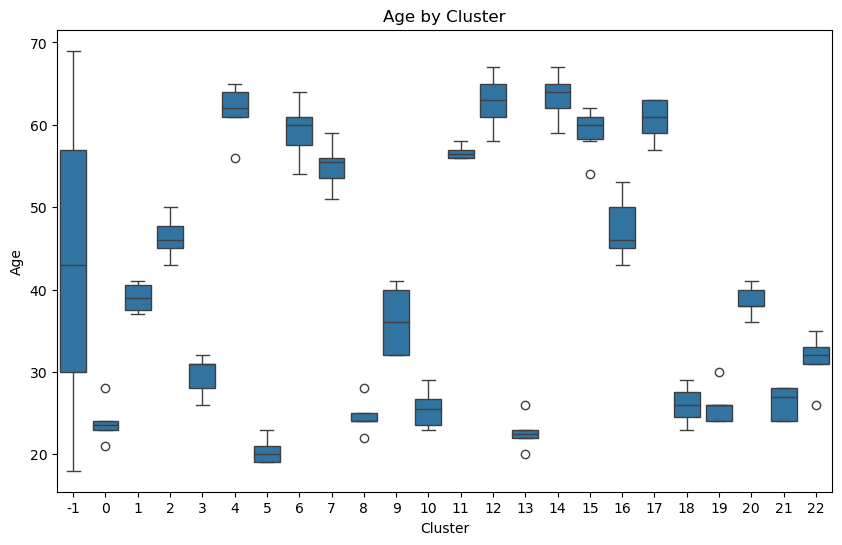

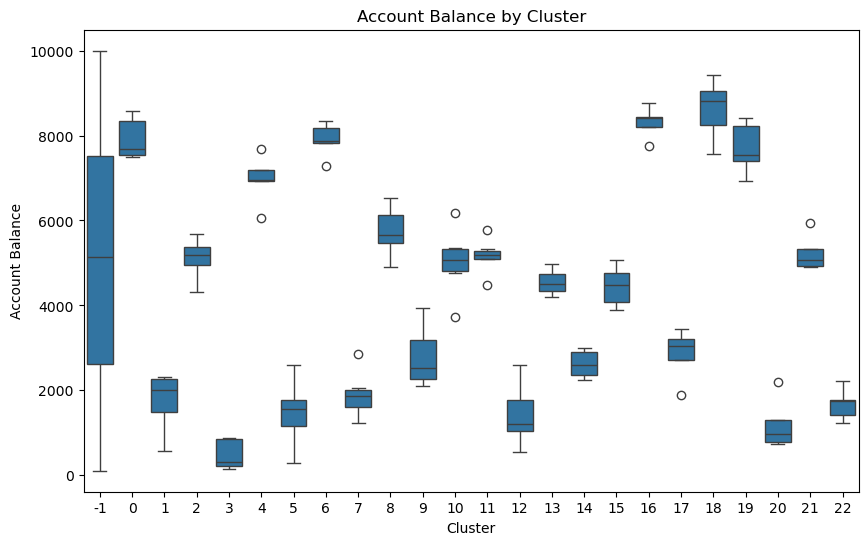

In [78]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='dbscan_cluster', y='age')
plt.title('Age by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Age')
plt.savefig('../images/users_age_by_clusters.png');

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='dbscan_cluster', y='acc_bal')
plt.title('Account Balance by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Account Balance')
plt.savefig('../images/users_acc_bal_by_clusters.png');

#### Hyperparameter Tuning

In [79]:
# range of eps and min_sample values 
eps_values = [0.1, 0.2, 0.3, 0.5, 0.7, 1]  
min_samples_values = [3, 5, 7]

# store best results 
best_score = 0
best_eps = None
best_min_samples = None

# iterate through the range of eps and min_sample values
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(df_scaled)
        
        if len(set(labels)) > 1 and -1 in labels:
            score = silhouette_score(df_scaled, labels)
            print(f"eps={eps}, min_samples={min_samples}, silhouette_score={score:.3f}")
            
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

eps=0.2, min_samples=3, silhouette_score=-0.005
eps=0.3, min_samples=3, silhouette_score=-0.317
eps=0.5, min_samples=3, silhouette_score=-0.455
eps=0.5, min_samples=5, silhouette_score=-0.474
eps=0.5, min_samples=7, silhouette_score=-0.038
eps=0.7, min_samples=3, silhouette_score=-0.407
eps=0.7, min_samples=5, silhouette_score=-0.389
eps=0.7, min_samples=7, silhouette_score=-0.351
eps=1, min_samples=3, silhouette_score=0.190
eps=1, min_samples=5, silhouette_score=0.190
eps=1, min_samples=7, silhouette_score=0.192


#### DBSCAN using best parameters

In [80]:
dbscan_best = DBSCAN(eps=1, min_samples=7)
dbscan_labels_best = dbscan.fit_predict(df_scaled)

In [81]:
df['dbscan_cluster'] = dbscan_labels_best

In [82]:
n_clusters = len(set(dbscan_labels_best)) - (1 if -1 in dbscan_labels_best else 0) 
n_noise = list(dbscan_labels_best).count(-1)

In [83]:
print(f'Number of clusters found: {n_clusters}')
print(f'Number of noise points: {n_noise}')

Number of clusters found: 3
Number of noise points: 20


In [84]:
silhouette_score(df_scaled, dbscan.labels_)

0.19156365521040034

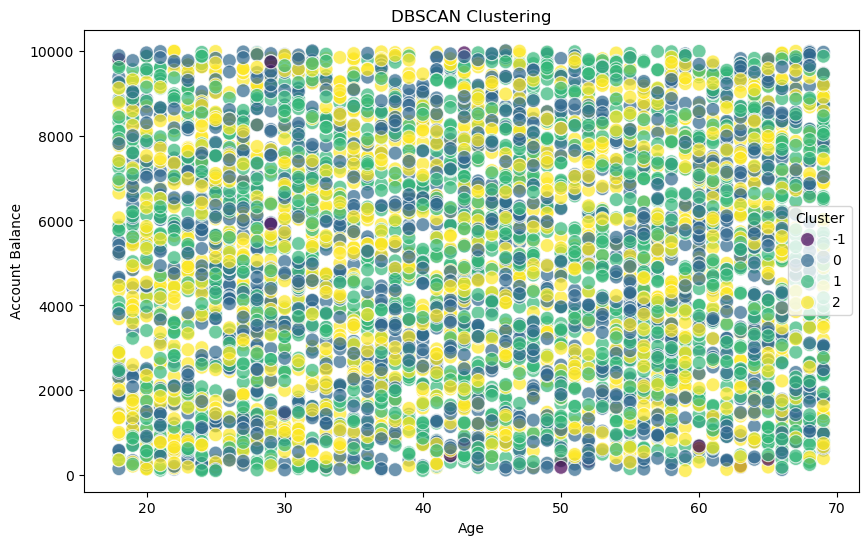

In [85]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='age', y='acc_bal', hue='dbscan_cluster', palette='viridis', s=100, alpha=0.7)
plt.title('DBSCAN Clustering')
plt.xlabel('Age')
plt.ylabel('Account Balance')
plt.legend(title='Cluster')
plt.savefig('../images/users_dbscan_cluster_best.png');

Despite hyperparameter tuning, it is obvious that we are unable to draw any conclusive or relevant conclusions from our model and the clusters. 

In [86]:
cluster_summary = df.groupby('dbscan_cluster').agg({
    'age': ['mean', 'median'],
    'acc_bal': ['mean', 'median'],
    'credit_bal': ['mean', 'median']
}).round(2)

print("Cluster Summary Statistics:")
print(cluster_summary)

Cluster Summary Statistics:
                  age         acc_bal          credit_bal         
                 mean median     mean   median       mean   median
dbscan_cluster                                                    
-1              45.30   43.0  3976.61   812.53    2094.85  1585.65
 0              43.62   43.0  5075.93  5067.77    2502.33  2467.84
 1              44.02   44.0  5041.16  5046.63    2482.65  2473.08
 2              42.71   43.0  5079.05  5169.21    2482.36  2453.89


### Conclusions 

Our models **did not** yield useful insights and produced low silhouette scores due to the nature of the dataset. We can see a lack of clear patterns or natural groups within the user data. As we can see from our EDA, the variables are highly dispersed and lack significant correlations which makes it very difficult for clustering algorithms like KMeans and DBSCAN to identify distinct clusters. Let's take a deeper look at why our models did not work in the way we expected. 

**Lack of Natural Clusters:** While clustering, it is evident that these algorithms work best when there are well-defined groups or natural seperations within the data. However, in this dataset we can see that the variables are spread out and do not yield any meaningful correlations. 

**High Dimensionality with Low Correlation:** High-dimensional data with low correlations can confuse clustering alogrithms. Here, we can see that the "clusters" tend to overlap which results in a low silhoutte score. 

**KMeans:** This algorithm is best suited for data with distinct, evenly shaped clusters. This is obviously not the case for our dataset. 

**DBSCAN:** This algorithm depends on dense regions to form clusters and with our data being so widely distributed, it makes it difficult for the model to identify meaningful clusters. 


Moving forward, we would like to explore the user data using a different dataset that yields more patterns and correlations. This would allow for the models to provide greater insights and cluster the data more effectively. Also, one way we could improve our clustering is by refining our features to help reveal hidden clusters. Due to the current data's already low correlations, we do not have any actionable insights. We are therefore making assumptions and dividing our users into high-risk, medium-risk and low-risk investors. This allows us to work towards our goal of creating individual portfolio reccomendations for different user types. 
